# Measurement Error Mitigation

## Opis metody

Błędy w obecnych komputerach kwantowych są złożonym problemem i istnieje kilka ich przyczyn. Jedną z nich jest błąd przy końcowym pomiarze stanu układu kwantowego, który to pomiar generuje szum. W celu ograniczenia tego zjawiska możemy wykorzystać metodę zmniejszania błędu pomiarowego:

1. Przygotowujemy 2^n kalibracyjnych układów kwantowych (gdzie n jest równe ilości qubitów w eksperymencie, którego wyniki chcemy poprawić), każdy w innym n-qubitowym stanie bazowym. Układ kalibracyjny składa się w zasadzie tylko z bramek ustalających stan wejściowy qubitów i bramek pomiarowych
2. Wykonujemy układy z punktu 1. na komputerze kwantowym w celu zmierzenia błędów pomiarowych (mała wielkość układów pozwala ograniczyć dekoherencję)
3. Wypełniamy macierz M rzeczywistymi wynikami pomiarów dla każdego stanu bazowego (kolumny są wektorami pomiarów)
4. Obliczamy macierz odwrotną do macierzy M w celu wykorzystania jej do poprawy błędów 
5. Mnożymy wyniki eksperymentu, który chcemy poprawić, przez macierz odwrotną do macierzy M

## Zastosowanie metody do książkowego rozwiązania algorytmu Grovera

In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq import least_busy

provider = IBMQ.load_account()

In [2]:
def sandwich(circuit, qbits, sandwiching, inside):
    for i in qbits:
        sandwiching(circuit, i)
    inside(circuit)
    for i in qbits:
        sandwiching(circuit, i)

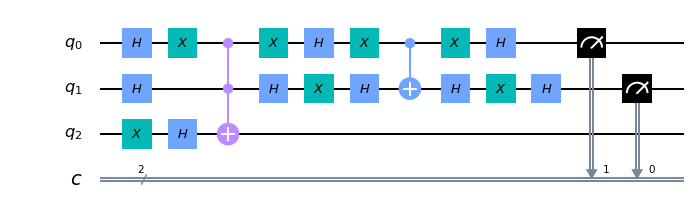

In [3]:
circ = QuantumCircuit(3, 2)
circ.x(2)
circ.h(0)
circ.h(1)
circ.h(2)
sandwich(circ, [0], lambda c, i: c.x(i), lambda c: c.toffoli(0,1,2))
circ.h(0)
circ.h(1)
circ.x(0)
circ.x(1)
circ.h(1)
circ.cx(0,1)
circ.h(1)
circ.x(0)
circ.x(1)
circ.h(0)
circ.h(1)
circ.measure([0,1], [1,0])
circ.draw()

Experiment {'00': 120, '01': 729, '11': 121, '10': 54}


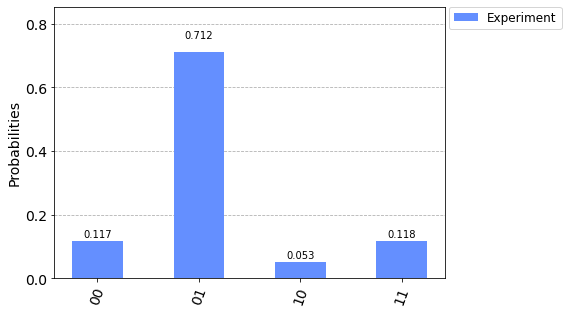

In [4]:
provider = IBMQ.get_provider(group='open')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))

job_exp = execute(circ, backend=backend, shots=1024)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(circ)
print("Experiment", counts_exp)
plot_histogram([counts_exp], legend=['Experiment'])

Jak widzimy wyniki obarczone są błędem. W układzie idealnym stan `|01>` miałby prawdopodobieństwo wystąpienia równe 1

In [5]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

### Generowanie układów kalibracyjnych dla rejestru 2-qubitowego (pomiar 3 qubitu z rejestru nie jest potrzebny, nie jest więc przeprowadzany):

In [6]:
meas_calibs, state_labels = complete_meas_cal(qubit_list = [0, 1], qr=circ.qregs[0], circlabel='mcal')
for circuit in meas_calibs:
    print('Circuit', circuit.name)
    print(circuit)

Circuit mcalcal_00
       ░ ┌─┐   
 q_0: ─░─┤M├───
       ░ └╥┘┌─┐
 q_1: ─░──╫─┤M├
       ░  ║ └╥┘
 q_2: ─░──╫──╫─
       ░  ║  ║ 
c0_0: ════╩══╬═
             ║ 
c0_1: ═══════╩═
               
Circuit mcalcal_01
      ┌───┐ ░ ┌─┐   
 q_0: ┤ X ├─░─┤M├───
      └───┘ ░ └╥┘┌─┐
 q_1: ──────░──╫─┤M├
            ░  ║ └╥┘
 q_2: ──────░──╫──╫─
            ░  ║  ║ 
c0_0: ═════════╩══╬═
                  ║ 
c0_1: ════════════╩═
                    
Circuit mcalcal_10
            ░ ┌─┐   
 q_0: ──────░─┤M├───
      ┌───┐ ░ └╥┘┌─┐
 q_1: ┤ X ├─░──╫─┤M├
      └───┘ ░  ║ └╥┘
 q_2: ──────░──╫──╫─
            ░  ║  ║ 
c0_0: ═════════╩══╬═
                  ║ 
c0_1: ════════════╩═
                    
Circuit mcalcal_11
      ┌───┐ ░ ┌─┐   
 q_0: ┤ X ├─░─┤M├───
      ├───┤ ░ └╥┘┌─┐
 q_1: ┤ X ├─░──╫─┤M├
      └───┘ ░  ║ └╥┘
 q_2: ──────░──╫──╫─
            ░  ║  ║ 
c0_0: ═════════╩══╬═
                  ║ 
c0_1: ════════════╩═
                    


### Wykonanie układów kalibracyjnych na urządzeniu

In [7]:
job = execute(meas_calibs, backend=backend, shots=1024, optimization_level=0)
cal_results = job.result()

### Obliczenie macierzy M i macierzy do niej odwrotnej

In [8]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.98046875 0.0625     0.04785156 0.0078125 ]
 [0.00585938 0.92089844 0.         0.05175781]
 [0.01367188 0.00195312 0.94726562 0.05371094]
 [0.         0.01464844 0.00488281 0.88671875]]


### Macierz korelacji pomiędzy stanami przygotowanymi a zmierzonymi

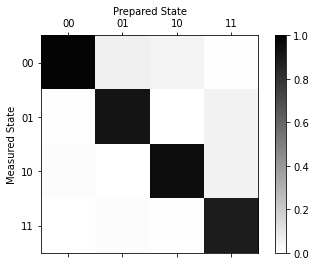

In [9]:
meas_fitter.plot_calibration()

### Wykorzystanie macierzy odwrotnej do poprawienia wyników eksperymentu

In [10]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(result_exp)

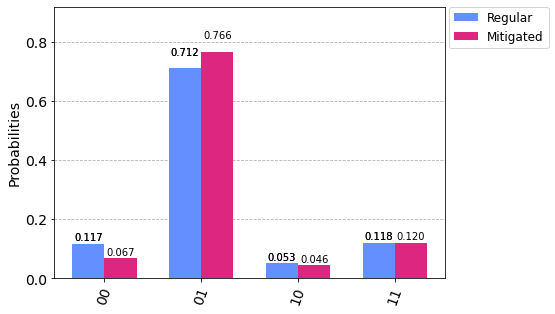

In [13]:
device_counts = result_exp.get_counts(circ)
mitigated_counts = mitigated_result.get_counts(circ)
plot_histogram([device_counts, mitigated_counts], legend=["Regular", "Mitigated"])

Wyniki eksperymentu poprawiły się nieznacznie. W przypadku tej implementacji algorytmu Grovera błędy spowodowane są najprawdopodobniej dużą liczbą bramek a nie samym pomiarem, dlatego poprawa blędów pomiarowych nie daje nam zdecydowanie lepszych wyników. Widać jednak pewną poprawę (na przykład prawdopodobieństwo otrzymania stanu `|00>` zmniejszyło się prawie o połowę, jednak prawdopodobieństwo otrzymania stanu `|11>` jest nawet nieznacznie większe. Prawdopodobieństwo otrzymania stanu oczekiwanego `|01>` również zwiększyło się o ok. 7% 